In [1]:
import numpy as np
import pandas as pd
import scipy as sc

from importlib import reload
from time import time
import matplotlib

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

## Load data

In [2]:
# load data with PTM labels and ground-truth and predicted disorder labels
# processed in process-data-and-train-model.ipynb
ptm_idr_df = pd.read_csv('data/ptm_idr.csv')
ptm_idr_df

,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,...,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered,pred_disordered
0,O00151,K,22,1,0,0,0,0,0,0,...,72.818182,77.428571,74.774194,74.951220,75.319149,76.500000,76.877193,0.0,1.0,0.022424
1,O00151,K,71,0,0,0,0,0,0,0,...,75.000000,77.809524,72.483871,67.268293,64.294118,61.786885,59.450704,0.0,1.0,0.057403
2,O00151,K,87,0,0,0,0,0,1,0,...,33.000000,41.095238,41.419355,43.170732,43.764706,43.491803,44.070423,0.0,1.0,0.245860
3,O00151,T,34,0,0,0,0,0,0,0,...,80.727273,78.380952,79.193548,80.560976,77.980392,77.754098,76.695652,0.0,1.0,0.017603
4,O00168,S,82,0,0,0,0,0,0,0,...,18.454545,16.761905,16.384615,16.806452,17.638889,19.756098,22.000000,0.0,1.0,0.433978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10797,Q9Y6W3,S,697,0,0,0,0,0,0,0,...,101.818182,105.047619,103.870968,113.097561,115.352941,124.655738,129.366197,0.0,1.0,0.006763
10798,Q9Y6W3,S,700,0,0,0,0,0,0,0,...,93.454545,98.857143,102.258065,110.756098,110.725490,121.901639,129.845070,0.0,1.0,0.006944
10799,Q9Y6W6,K,380,0,0,0,0,0,0,0,...,114.909091,129.333333,127.290323,123.536585,124.137255,128.213115,129.056338,0.0,1.0,0.004483
10800,Q9Y6Y9,Y,131,0,0,0,0,0,0,0,...,97.272727,85.666667,88.677419,94.707317,92.862745,87.200000,84.169231,0.0,1.0,0.016282


In [32]:
ptm_names = ['ac', 'ac_reg', 'ga', 'gl', 'gl_reg', 'm', 'm_reg', 'p', 'p_reg', 'sm', 'sm_reg', 'ub', 'ub_reg']
N_ptm = [len(ptm_idr_df.loc[ptm_idr_df[name] == 1]) for name in ptm_names]
idx = np.argsort(N_ptm)[::-1]
for i in idx:
    print(ptm_names[i], N_ptm[i])

p 6017
ub 3738
ac 1171
p_reg 663
m 442
sm 361
ac_reg 68
ub_reg 66
sm_reg 56
ga 47
gl 23
m_reg 11
gl_reg 3


In [8]:
len(ptm_idr_df.loc[ptm_idr_df.protein_id == 'Q9Y6W3'])

5

## Construct confidence intervals on odds ratio

In [ ]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(200), np.log10(N - 100), num=10, base=10).astype(int)
n_trial = 500
# m_reg, gl_reg left
# TODO: p_reg, n = 10702 ran into assertion error on assert(ratio_mu1[0] <= ratio_mu1[1])? but
# everything up until then fine and saved in finite-population-logistic-results-010622.csv

# ptm_names = ['p', 'ub', 'ac', 'p_reg', 'm', 'sm', 'ac_reg', 'ub_reg', 'sm_reg', 'ga', 'gl']
ptm_names = ['m', 'sm', 'ac_reg', 'ub_reg', 'sm_reg', 'ga', 'gl']
alpha = 0.1
grid_spacing = 1e-3
print_every = 100
save = True
save_fname = 'finite-population-logistic-results-010622-part2.csv'

columns = [
    'ptm', 'n', 'estimator',
    'mu1-lower', 'mu1-upper', 'mu1-coverage', 'mu1-width',
    'mu0-lower', 'mu0-upper', 'mu0-coverage', 'mu0-width',
    'o-lower', 'o-upper', 'o-coverage', 'o-width'
]
results = []

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            result = utils.get_odds_ratio_cis(
                ptm_idr_df, ptm_name, n, alpha, grid_spacing=grid_spacing, verbose=False
            )
            mu1, mu1_pp_ci, mu1_cl_ci, mu0, mu0_pp_ci, mu0_cl_ci, o, o_pp_ci, o_cl_ci = result
            mu1_cov_pp = (mu1_pp_ci[0] <= mu1) & (mu1_pp_ci[1] >= mu1)
            mu1_cov_cl = (mu1_cl_ci[0] <= mu1) & (mu1_cl_ci[1] >= mu1)
            mu0_cov_pp = (mu0_pp_ci[0] <= mu0) & (mu0_pp_ci[1] >= mu0)
            mu0_cov_cl = (mu0_cl_ci[0] <= mu0) & (mu0_cl_ci[1] >= mu0)
            o_cov_pp = (o_pp_ci[0] <= o) & (o_pp_ci[1] >= o)
            o_cov_cl = (o_cl_ci[0] <= o) & (o_cl_ci[1] >= o)
            
            # record results
            results.append(
                [ptm_name, n, 'prediction-powered',
                 mu1_pp_ci[0], mu1_pp_ci[1], mu1_cov_pp, mu1_pp_ci[1] - mu1_pp_ci[0],
                 mu0_pp_ci[0], mu0_pp_ci[1], mu0_cov_pp, mu0_pp_ci[1] - mu0_pp_ci[0],
                 o_pp_ci[0], o_pp_ci[1], o_cov_pp, o_pp_ci[1] - o_pp_ci[0]]
            )
            results.append(
                [ptm_name, n, 'classical',
                 mu1_cl_ci[0], mu1_cl_ci[1], mu1_cov_cl, mu1_cl_ci[1] - mu1_cl_ci[0],
                 mu0_cl_ci[0], mu0_cl_ci[1], mu0_cov_cl, mu0_cl_ci[1] - mu0_cl_ci[0],
                 o_cl_ci[0], o_cl_ci[1], o_cov_cl, o_cl_ci[1] - o_cl_ci[0]]
            )
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
        
        df = pd.DataFrame(results, columns=columns)
        if save:
            df.to_csv(save_fname)
            
        print('  Avg. PP width: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'prediction-powered')]['o-width'].mean()))
        print('  Avg. classical width: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'classical')]['o-width'].mean()))
        print('  PP coverage: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'prediction-powered')]['o-coverage'].mean()))
        print('  Classical coverage: {:.2f}'.format(
            df.loc[(df.ptm == ptm_name) & (df.n == n) & (df.estimator == 'classical')]['o-coverage'].mean()))
        print('{:d} s'.format(int(time() - t0)))

PTM = m, n = 200
  Done with 100 trials. 30 s
  Done with 200 trials. 62 s
  Done with 300 trials. 94 s


In [194]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(200), np.log10(N - 100), num=20, base=10).astype(int)
ns = ns[np.where(ns >= 1068)[0][0] :]
n_trial = 1000
ptm_names = ['ac']
alpha = 0.1
grid_spacing = 1e-3
print_every = 200
save = True
save_fname = 'sampling-sites-wor-cis-logistic-111022_3.npz'

mu1maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
omaici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
oclaci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
ocov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            lab_idx = np.random.choice(N, n, replace=False)
            result = utils.get_odds_ratio_betting_ci(
                ptm_idr_df, ptm_name, lab_idx, alpha, grid_spacing=grid_spacing, verbose=False
            )
            o, o_mai_ci, o_cla_ci, mu1, mu1_mai_ci, mu1_cla_ci, mu0, mu0_mai_ci, mu0_cla_ci = result

            # record results
            mu1maici_pxnxtx2[p_idx, n_idx, t] = mu1_mai_ci
            mu1claci_pxnxtx2[p_idx, n_idx, t] = mu1_cla_ci
            mu1cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu1 >= mu1_mai_ci[0]) & (mu1 <= mu1_mai_ci[1])
            mu1cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu1 >= mu1_cla_ci[0]) & (mu1 <= mu1_cla_ci[1])
            mu0maici_pxnxtx2[p_idx, n_idx, t] = mu0_mai_ci
            mu0claci_pxnxtx2[p_idx, n_idx, t] = mu0_cla_ci
            mu0cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu0 >= mu0_mai_ci[0]) & (mu0 <= mu0_mai_ci[1])
            mu0cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu0 >= mu0_cla_ci[0]) & (mu0 <= mu0_cla_ci[1])
            omaici_pxnxtx2[p_idx, n_idx, t] = o_mai_ci
            oclaci_pxnxtx2[p_idx, n_idx, t] = o_cla_ci
            ocov_pxnxtx2[p_idx, n_idx, t, 0] = (o >= o_mai_ci[0]) & (o <= o_mai_ci[1])
            ocov_pxnxtx2[p_idx, n_idx, t, 1] = (o >= o_cla_ci[0]) & (o <= o_cla_ci[1])
            
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
            
        print('  Average model-assisted CI length: {:.2f}'.format(
            np.mean(omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Average classical CI length: {:.2f}'.format(
            np.mean(oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Model-assisted CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Classical CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 1])))
        print('{:d} s'.format(int(time() - t0)))
        if save:
            np.savez(
                save_fname,
                mu1maici_pxnxtx2=mu1maici_pxnxtx2,
                mu1claci_pxnxtx2=mu1claci_pxnxtx2,
                mu1cov_pxnxtx2=mu1cov_pxnxtx2,
                mu0maici_pxnxtx2=mu0maici_pxnxtx2,
                mu0claci_pxnxtx2=mu0claci_pxnxtx2,
                mu0cov_pxnxtx2=mu0cov_pxnxtx2,
                omaici_pxnxtx2=omaici_pxnxtx2,
                oclaci_pxnxtx2=oclaci_pxnxtx2,
                ocov_pxnxtx2=ocov_pxnxtx2
            )

PTM = ac, n = 1068
  Done with 200 trials. 80 s
  Done with 400 trials. 157 s
  Done with 600 trials. 237 s
  Done with 800 trials. 316 s
  Done with 1000 trials. 394 s
  Average model-assisted CI length: 0.90
  Average classical CI length: 1.41
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
394 s
PTM = ac, n = 1317
  Done with 200 trials. 83 s
  Done with 400 trials. 169 s
  Done with 600 trials. 254 s
  Done with 800 trials. 339 s
  Done with 1000 trials. 422 s
  Average model-assisted CI length: 0.79
  Average classical CI length: 1.21
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
422 s
PTM = ac, n = 1624
  Done with 200 trials. 89 s
  Done with 400 trials. 178 s
  Done with 600 trials. 267 s
  Done with 800 trials. 357 s
  Done with 1000 trials. 446 s
  Average model-assisted CI length: 0.70
  Average classical CI length: 1.07
  Model-assisted CI coverage: 0.98
  Classical CI coverage: 0.99
446 s
PTM = ac, n = 2003
  Done with 200 trials. 100 s


/home/clarafy/waterslides/model-assisted-inference/alphafold/utils.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  """


  Done with 200 trials. 238 s
  Done with 400 trials. 477 s
  Done with 600 trials. 719 s
  Done with 800 trials. 955 s
  Done with 1000 trials. 1187 s
  Average model-assisted CI length: inf
  Average classical CI length: 0.38
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.98
1187 s
PTM = ac, n = 10702
  Done with 200 trials. 273 s
  Done with 400 trials. 545 s
  Done with 600 trials. 817 s
  Done with 800 trials. 1091 s
  Done with 1000 trials. 1364 s
  Average model-assisted CI length: 0.22
  Average classical CI length: 0.38
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
1364 s


## Plot results

In [2]:
# load data with PTM labels and ground-truth and predicted disorder labels
# processed in process-data-and-train-model.ipynb
ptm_idr_df = pd.read_csv('data/ptm_idr.csv')
N = len(ptm_idr_df)

In [18]:
np.savez(
    'results-finite-population-111022.npz',
    mu1maici_pxnxtx2=mu1maici_pxnxtx2,
    mu1claci_pxnxtx2=mu1claci_pxnxtx2,
    mu0maici_pxnxtx2=mu0maici_pxnxtx2,
    mu0claci_pxnxtx2=mu0claci_pxnxtx2,
    omaici_pxnxtx2=omaici_pxnxtx2,
    oclaci_pxnxtx2=oclaci_pxnxtx2
)

In [3]:
d = np.load('results-finite-population-111022.npz')
mu1maici_pxnxtx2 = d['mu1maici_pxnxtx2']
mu1claci_pxnxtx2 = d['mu1claci_pxnxtx2']
mu0maici_pxnxtx2 = d['mu0maici_pxnxtx2']
mu0claci_pxnxtx2 = d['mu0claci_pxnxtx2']
omaici_pxnxtx2 = d['omaici_pxnxtx2']
oclaci_pxnxtx2 = d['oclaci_pxnxtx2']

In [2]:
d = np.load('sampling-sites-wor-cis-logistic-111022.npz')
mu1maici_pxnxtx2 = d['mu1maici_pxnxtx2']
mu1claci_pxnxtx2 = d['mu1claci_pxnxtx2']
mu0maici_pxnxtx2 = d['mu0maici_pxnxtx2']
mu0claci_pxnxtx2 = d['mu0claci_pxnxtx2']
omaici_pxnxtx2 = d['omaici_pxnxtx2']
oclaci_pxnxtx2 = d['oclaci_pxnxtx2']

d2 = np.load('sampling-sites-wor-cis-logistic-111022_2.npz')
mu1maici_pxnxtx2_2 = d2['mu1maici_pxnxtx2']
mu1claci_pxnxtx2_2 = d2['mu1claci_pxnxtx2']
mu0maici_pxnxtx2_2 = d2['mu0maici_pxnxtx2']
mu0claci_pxnxtx2_2 = d2['mu0claci_pxnxtx2']
omaici_pxnxtx2_2 = d2['omaici_pxnxtx2']
oclaci_pxnxtx2_2 = d2['oclaci_pxnxtx2']

d3 = np.load('sampling-sites-wor-cis-logistic-111022_3.npz')
mu1maici_pxnxtx2_3 = d3['mu1maici_pxnxtx2']
mu1claci_pxnxtx2_3 = d3['mu1claci_pxnxtx2']
mu0maici_pxnxtx2_3 = d3['mu0maici_pxnxtx2']
mu0claci_pxnxtx2_3 = d3['mu0claci_pxnxtx2']
omaici_pxnxtx2_3 = d3['omaici_pxnxtx2']
oclaci_pxnxtx2_3 = d3['oclaci_pxnxtx2']

mu1maici_pxnxtx2 = np.concatenate([mu1maici_pxnxtx2, mu1maici_pxnxtx2_2], axis=2)
assert(np.sum(mu1maici_pxnxtx2[-1, 8 :,  1000 :]) == 0)
mu1maici_pxnxtx2[-1, 8 :, 1000 :] = mu1maici_pxnxtx2_3[0]
print(mu1maici_pxnxtx2.shape)

mu1claci_pxnxtx2 = np.concatenate([mu1claci_pxnxtx2, mu1claci_pxnxtx2_2], axis=2)
assert(np.sum(mu1claci_pxnxtx2[-1, 8 :,  1000 :]) == 0)
mu1claci_pxnxtx2[-1, 8 :, 1000 :] = mu1claci_pxnxtx2_3[0]
print(mu1claci_pxnxtx2.shape)

mu0maici_pxnxtx2 = np.concatenate([mu0maici_pxnxtx2, mu0maici_pxnxtx2_2], axis=2)
assert(np.sum(mu0maici_pxnxtx2[-1, 8 :,  1000 :]) == 0)
mu0maici_pxnxtx2[-1, 8 :, 1000 :] = mu0maici_pxnxtx2_3[0]
print(mu0maici_pxnxtx2.shape)

mu0claci_pxnxtx2 = np.concatenate([mu0claci_pxnxtx2, mu0claci_pxnxtx2_2], axis=2)
assert(np.sum(mu0claci_pxnxtx2[-1, 8 :,  1000 :]) == 0)
mu0claci_pxnxtx2[-1, 8 :, 1000 :] = mu0claci_pxnxtx2_3[0]
print(mu0claci_pxnxtx2.shape)

omaici_pxnxtx2 = np.concatenate([omaici_pxnxtx2, omaici_pxnxtx2_2], axis=2)
assert(np.sum(omaici_pxnxtx2[-1, 8 :,  1000 :]) == 0)
omaici_pxnxtx2[-1, 8 :, 1000 :] = omaici_pxnxtx2_3[0]
print(omaici_pxnxtx2.shape)

oclaci_pxnxtx2 = np.concatenate([oclaci_pxnxtx2, oclaci_pxnxtx2_2], axis=2)
assert(np.sum(oclaci_pxnxtx2[-1, 8 :,  1000 :]) == 0)
oclaci_pxnxtx2[-1, 8 :, 1000 :] = oclaci_pxnxtx2_3[0]
print(oclaci_pxnxtx2.shape)


(3, 20, 2000, 2)
(3, 20, 2000, 2)
(3, 20, 2000, 2)
(3, 20, 2000, 2)
(3, 20, 2000, 2)
(3, 20, 2000, 2)


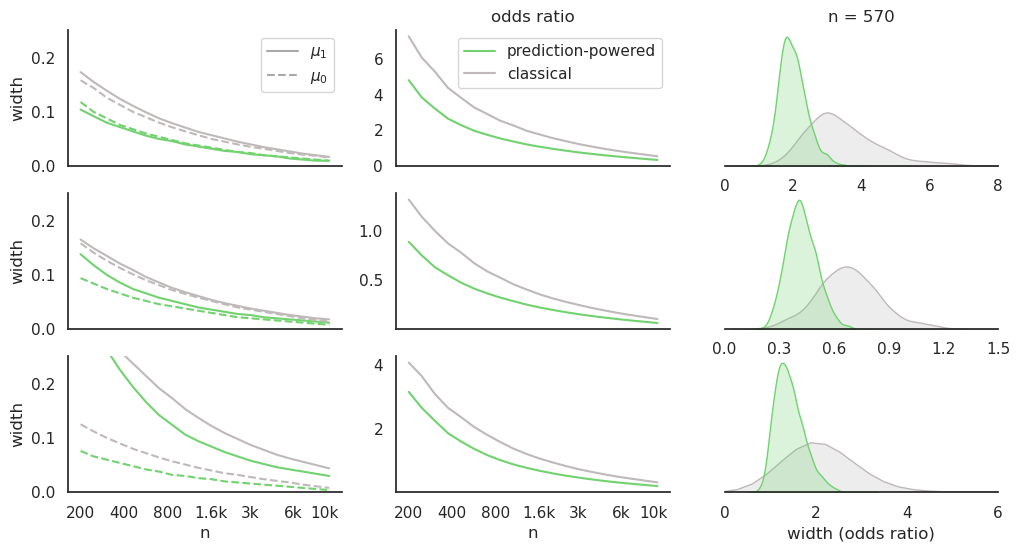

In [4]:
save = False

my_palette = sns.color_palette(["#71D26F", "#BFB9B9",], 2)
sns.set_theme(style="white", palette=my_palette)

# sns.set_theme(style='white', palette="pastel")
ns = np.logspace(np.log10(200), np.log10(N - 100), num=20, base=10).astype(int)
n_idx = np.where(ns >= 500)[0][0]
ptm_names = ['p', 'ub', 'ac']
fig, axs = plt.subplots(len(ptm_names), 3, figsize=(12, len(ptm_names) * 2))

t = mu1maici_pxnxtx2.shape[2]
inference_2t = t * ['model-assisted'] + t * ['classical']
ns_xticks = [200, 400, 800, 1600, 3000, 6000, 10000]
ns_xticklabels = [200, 400, 800, '1.6k', '3k', '6k', '10k']

hist_xlims = [[0, 8], [0, 1.5], [0, 6]]
hist_xticks = [np.arange(0, 9, 2), np.arange(0, 1.6, 0.3), np.arange(0, 7, 2)]
for p_idx, ptm_name in enumerate(ptm_names):
    
    # ===== left subplots =====
    
    # mu1
    mu1maicilen_n = np.median(mu1maici_pxnxtx2[p_idx, :, :, 1] - mu1maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu1clacilen_n = np.median(mu1claci_pxnxtx2[p_idx, :, :, 1] - mu1claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu1maicilen_n)
    axs[p_idx, 0].plot(ns, mu1clacilen_n)
    
    # mu0
    mu0maicilen_n = np.median(mu0maici_pxnxtx2[p_idx, :, :, 1] - mu0maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu0clacilen_n = np.median(mu0claci_pxnxtx2[p_idx, :, :, 1] - mu0claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu0maicilen_n, c=my_palette[0], linestyle='--')
    axs[p_idx, 0].plot(ns, mu0clacilen_n, c=my_palette[1], linestyle='--')        
    
    axs[p_idx, 0].set_xscale('log');
    axs[p_idx, 0].set_xticks([])
    
    axs[p_idx, 0].set_ylabel('width');
    axs[p_idx, 0].set_ylim([0, 0.25]);
    sns.despine(ax=axs[p_idx, 0], top=True, right=True)
    
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='-', c='DarkGray', label='$\mu_1$')
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='--', c='DarkGray', label='$\mu_0$')
    
    # ===== middle subplots =====
    
    # odds ratio
    omaicilen_nxt = omaici_pxnxtx2[p_idx, :, :, 1] - omaici_pxnxtx2[p_idx, :, :, 0]
    oclacilen_nxt = oclaci_pxnxtx2[p_idx, :, :, 1] - oclaci_pxnxtx2[p_idx, :, :, 0]
    omaicilen_n = np.median(omaicilen_nxt, axis=1)
    oclacilen_n = np.median(oclacilen_nxt, axis=1)
    axs[p_idx, 1].plot(ns, omaicilen_n, label='prediction-powered')
    axs[p_idx, 1].plot(ns, oclacilen_n, label='classical')
    sns.despine(ax=axs[p_idx, 1], top=True, right=True)
    
    axs[p_idx, 1].set_xscale('log');
    axs[p_idx, 1].set_xticks([])
    
    # ===== right subplots
    
    len_2t = np.hstack([omaicilen_nxt[n_idx, :], oclacilen_nxt[n_idx, :]])
    hist_df = pd.DataFrame(len_2t, columns=['odds ratio CI width'])
    hist_df['estimator'] = inference_2t
    kde = sns.kdeplot(data=hist_df, x='odds ratio CI width', hue='estimator', ax=axs[p_idx, 2], fill=True);
    sns.despine(ax=axs[p_idx, 2], top=True, right=True, left=True)
    axs[p_idx, 2].set_yticks([])
    axs[p_idx, 2].set_ylabel('')
    axs[p_idx, 2].set_xlim(hist_xlims[p_idx])
    axs[p_idx, 2].set_xticks(hist_xticks[p_idx])
    axs[p_idx, 2].set_xlabel('width (odds ratio)')
    kde.get_legend().remove()
    
for i in [0, 1]:
    axs[-1, i].set_xticks(ns_xticks)
    axs[-1, i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[-1, i].set_xticklabels(ns_xticklabels)
    axs[-1, i].set_xlabel('n');
    axs[0, i].legend();
    axs[0, i].legend();
axs[0, 1].set_title('odds ratio');
axs[0, 2].set_title('n = {}'.format(ns[n_idx]));

if save:
    plt.savefig('./figures/widths.pdf', dpi=300, bbox_inches='tight')
plt.show()